<a href="https://colab.research.google.com/github/weldlabucsb/mcmc/blob/master/mcmc_nuts_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [93]:
!pip3 install arviz
!pip install lmfit

     |████████████████████████████████| 266kB 3.5MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 256kB 10.4MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81990 sha256=48c2f07a829cca0017d99114cdafdcfce99ab7f846fa9c32d08590a747f61684
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=5cb447bbc1b51029428b4ce53ab8ec91d550d655f30eb8810b3a43c62540ab84
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
Successfully built lmfit asteval


In [2]:
#Goal of this notebook is to create some simple code that can take a 1d array which we will suppose we have, i.e. it will be one of the inputs
#and we will take it and compare it to simulated data.

## Imports:
import pandas as pd
import seaborn as sns

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from multiprocessing import Process, Queue
import time
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from functools import partial
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from scipy.optimize import curve_fit
import arviz as az
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
sns.set_palette("muted")
np.random.seed(1324)
dtype=tf.float32
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (9, 6),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
plt.rcParams.update(params)
%config InlineBackend.figure_format = 'retina'

# Global Constants

In [5]:
# number of "pixels" on the direction
N = 150

# Data Import

We will take some data and turn it a 1d array with the data along a given direction.

The idea is that the data is a 2d matrix, we will interpolate it to get a function OD(x, y) that will provide the optical density at pixels x,y. We want to be able to slice it, so that we give a direction like \[0,1] or \[1,1] and with N bins. Each bin would represent a pixel. 

We have used the DataManager made by Peter to get a CSV file that I will use for this run.

Load the optical density (could add some kind of interworking with matlab maybe).

All of the od < 0 should be equal to 0.

In [6]:
#load csv file:
od = np.loadtxt(r"/content/drive/My Drive/Colab Notebooks/Weld Lab/data/optical density run 18.csv", delimiter=",", encoding='utf-8-sig').T
od[od < 0] = 0 #isn't this so easy with numpy?? How do you even do the same on matlab? Is it as easy, maybe?
od.shape

(41, 390)

In [7]:
#import scipy:
from scipy.interpolate import RectBivariateSpline

In [8]:
#@title Interpolation of OD
X = range(od.shape[0])
Y = range(od.shape[1])
optical_density = RectBivariateSpline(X, Y, od)

## Helper function to cut through the data

In [9]:
#@title Helper Function
#this function will provide an array of points, so X, and Y where X[i], Y[i]
#are places where to evaluate this the function along a given direction.
def points(start, end, Nx, Ny, N):
  x1 = start[0]
  y1 = start[1]
  x2, y2 = end
  line = lambda x: (y2-y1)/(x2-x1)*(x-x1)+y1
  
  
  xinit = (x2*y1-x1*y2)/(y1-y2)
  xfinal = (Ny*(x1-x2)-x1*y2+x2*y1)/(y1-y2)
  print(f"xinit is {xinit:.2f}, xfinal is {xfinal:.2f}.")
  if xinit<0:
    xinit = 0
  elif xinit > Nx:
    xinit = Nx
  if xfinal > Nx:
    xfinal = Nx
  elif xfinal < 0:
    xfinal = 0
  
  X = np.linspace(xinit, xfinal, N)
  Y = line(X)
  return (X, Y)

xinit is 295.00, xfinal is -262.14.


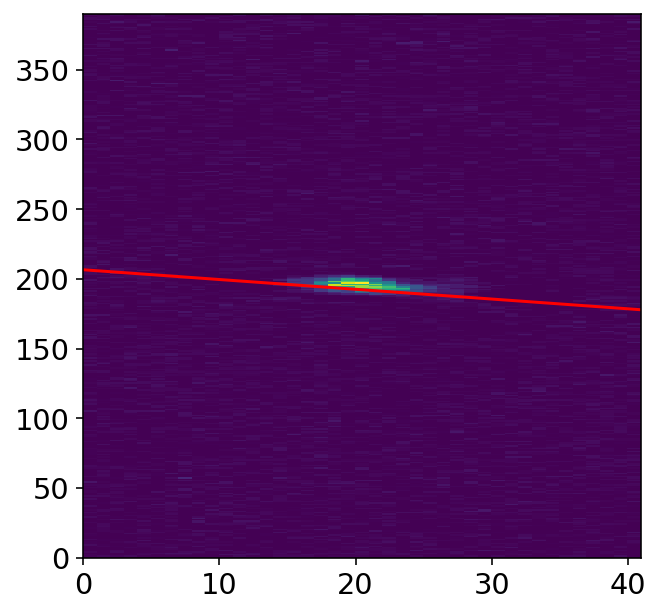

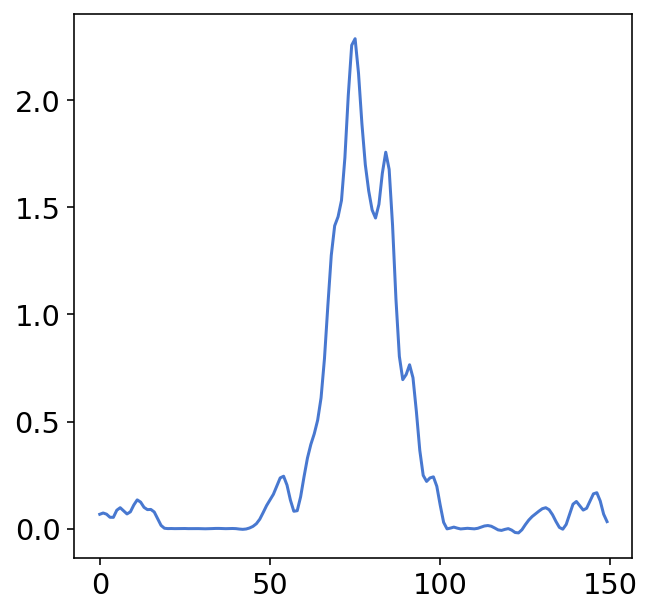

In [33]:
#@title Set up of the Slice
X, Y = points((15,196),(25,189), od.shape[0], od.shape[1], int(N))
plt.figure(figsize=(5,5))
plt.plot(X, Y, color="red")
plt.pcolormesh(od.T)
# xx, yy = np.meshgrid(X, Y)
# Z = optical_density(xx, yy)
# plt.pcolormesh(xx, yy, Z)
plt.xlim(0, od.shape[0])
plt.ylim(0, od.shape[1])
plt.figure(figsize=(5,5))
Slice = optical_density(X, Y, grid=False)
plt.plot(Slice)

RuntimeError: ignored

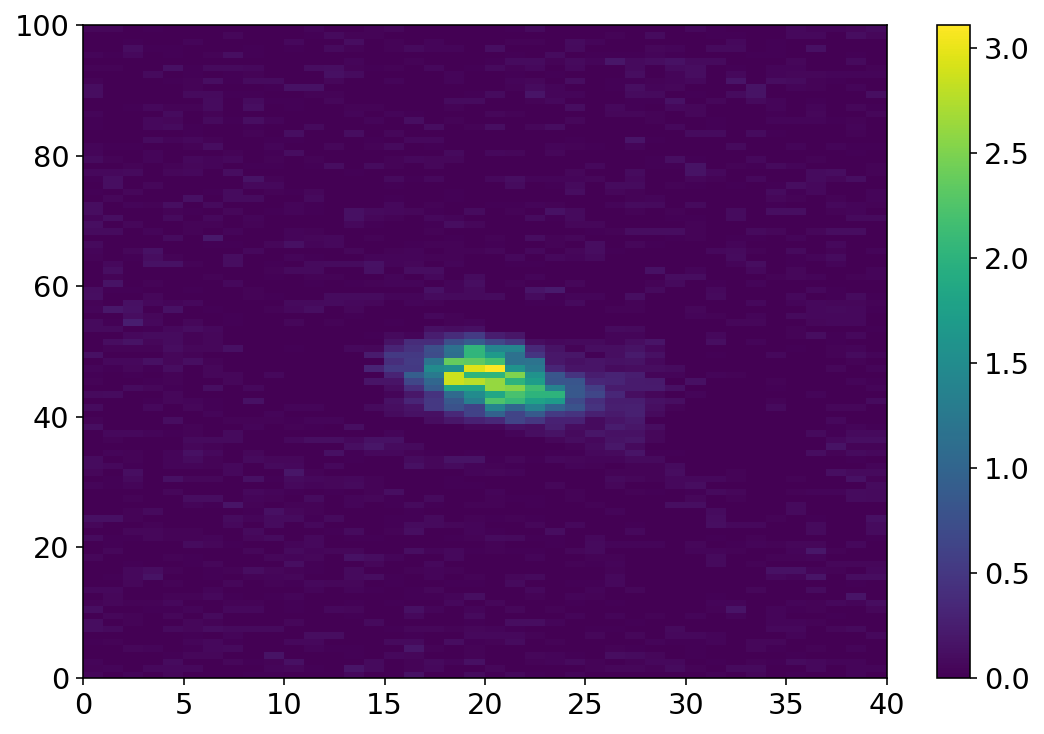

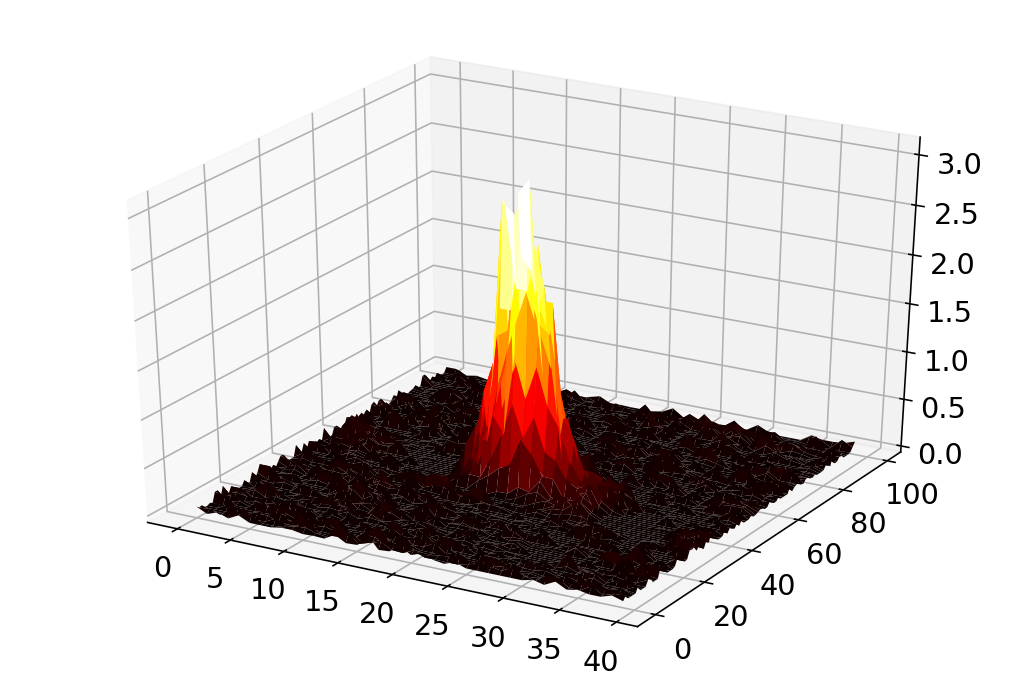

In [105]:
#@title 2D cut
AOI = np.array(((0, 40), (150, 250)))
cut2d = od[AOI[0, 0]:AOI[0,1], AOI[1,0]:AOI[1,1]].T

plt.pcolormesh(cut2d)
plt.colorbar()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = range(cut2d.shape[0])
y = range(cut2d.shape[1])

X, Y = np.meshgrid(y, x)

ax.plot_surface(X, Y, cut2d, rstride=1, cstride=1, cmap='hot')
# plt.colorbar()

In [177]:
#2d fit to the data:
from scipy.stats import multivariate_normal as mnormal
def gaussian_2d(X, amplitude, mu, cov):
  return amplitude*mnormal(mean=mu, cov=cov).pdf(X)
cov = np.array([[10,0], [0, 10]])
mu = np.array([5., 20.])
XY = np.dstack(np.meshgrid(y, x))

def gaussian_2d_ind(X, amplitude, mux, muy, sigmax, sigmay, ravel = False):
  mu = np.stack((mux, muy))
  # print(mu)
  cov = np.identity(2)*np.stack((sigmax, sigmay))
  # print("cov matrix ", cov)
  if ravel:
    return np.ravel(gaussian_2d(X, amplitude, mu, cov))
  return gaussian_2d(X, amplitude, mu, cov)
def rotate_xy_mesh(X, angle):
  rot = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
  return np.einsum('ji, inm -> jmn', rot, X)
# t = np.array([1,0])
print(XY.shape)
# print(np.reshape(rotate_xy(XY, np.pi/2), (100, 40,2)))
plt.pcolormesh(rotate_xy(gaussian_2d_ind(XY, 10., 5., 20., 10, 1), np.pi/2))
# plt.figure()
# plt.pcolormesh(gaussian_2d(rotate_xy(XY, np.pi/2), 10., mu, cov))

(100, 40, 2)


ValueError: ignored

In [130]:
def gaussian_2d_ext(xy_mesh, amp, xc, yc, sigma_x, sigma_y):
    
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    # make the 2D Gaussian matrix
    gauss = amp*np.exp(-((x-xc)**2/(2*sigma_x**2)+(y-yc)**2/(2*sigma_y**2)))/(2*np.pi*sigma_x*sigma_y)
    
    # flatten the 2D Gaussian down to 1D
    return np.ravel(gauss)

gaussian_2d_ext(np.meshgrid(np.arange(256), np.arange(256)), 1, 1, 1, 2,5)
test = np.dstack(np.meshgrid(np.arange(256), np.arange(256)))
print(test.shape)
print(np.dsplit(test, 2)[0].shape)

(256, 256, 2)
(256, 256, 1)


(100, 40, 2)


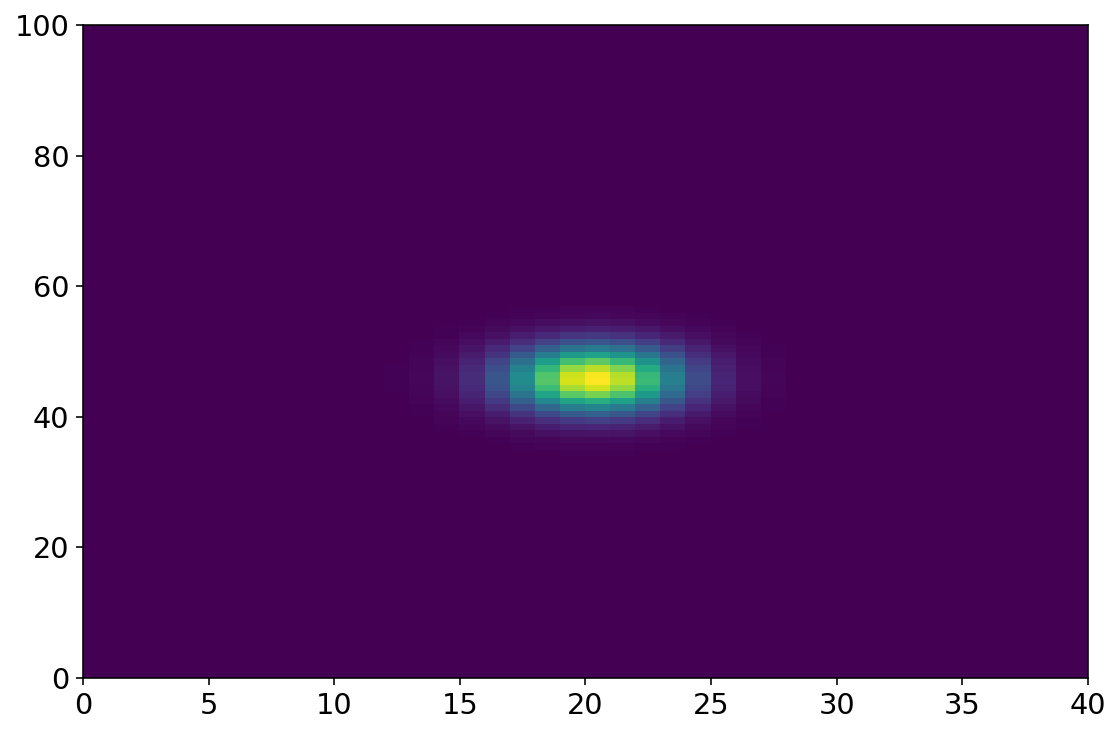

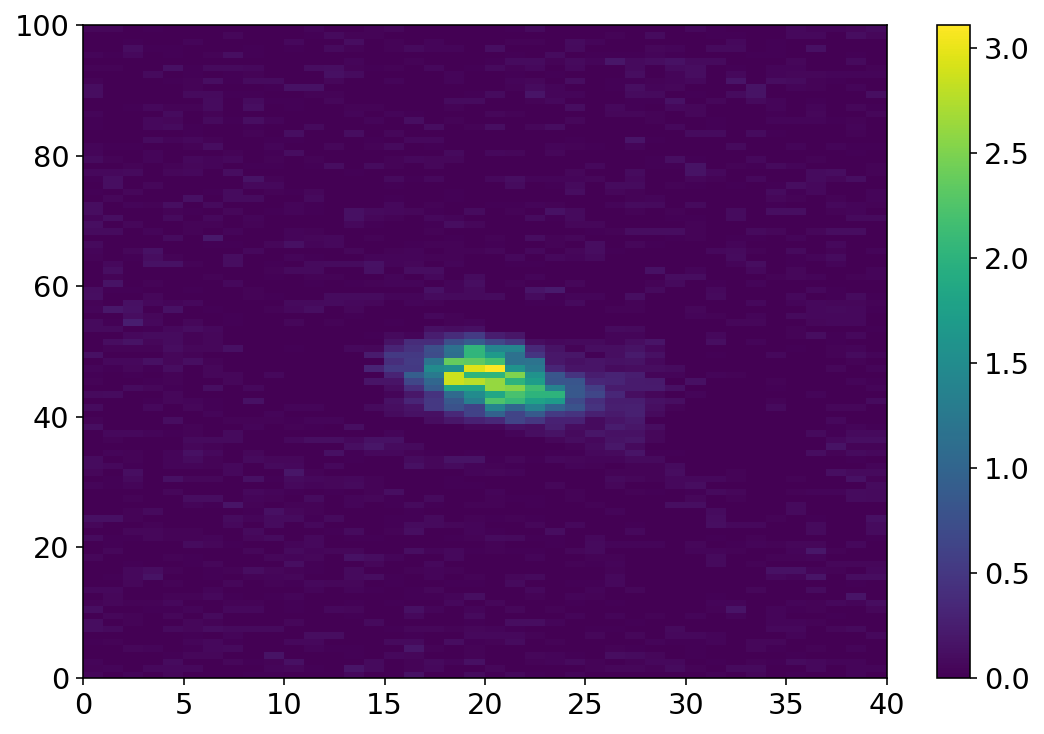

In [144]:
#@title 2d fit
from lmfit import Model
fit_func = lambda X, amplitude, mux, muy, sigmax, sigmay: gaussian_2d_ind(X, amplitude, mux, muy, sigmax, sigmay, ravel=True) #creates a closed version of the function
print(XY.shape)
# fit_func(XY, 10, 10, 10, 5, 5).shape

guess_vals = (3.0, 20., 40., 15., 5.)

fit_params, cov_mat = curve_fit(fit_func, XY, np.ravel(cut2d), p0=guess_vals, bounds=(0, np.inf))

# lmfit_model = Model(gaussian_2d_ind)

# lmfit_result = lmfit_model.fit(np.ravel(cut2d), 
#                                X=np.ravel(cut2d), 
#                                amplitude=guess_vals[0], 
#                                mux=guess_vals[1], 
#                                muy=guess_vals[2], 
#                                sigmax=guess_vals[3], 
#                                sigmay=guess_vals[4])
#plot fit:
plt.pcolormesh(gaussian_2d_ind(XY, *fit_params))
plt.figure()
plt.pcolormesh(cut2d)
plt.colorbar()

1.0017297961368354

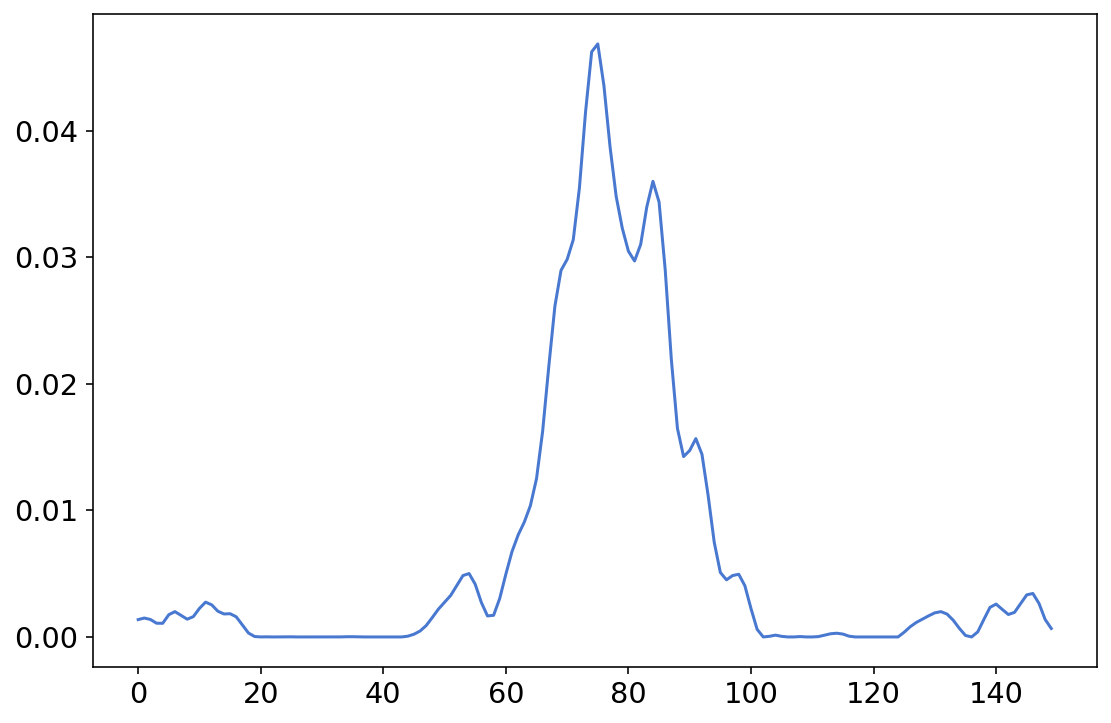

In [11]:
#@title Normalization of the Slice
#normalize the slice: (add option to normalise with true dx later)
from scipy.integrate import trapz
Slice = Slice/trapz(Slice)
#make sure there's no negative numbers:
Slice[Slice < 0] = 0
plt.plot(Slice)
trapz(Slice)

In [12]:
#@title Using Panda to keep tidy data
X = np.linspace(0, int(N), num=int(N), endpoint=False)
data = np.column_stack((X, Slice))
print(data)
df = pd.DataFrame(data, columns = ['x','od'])

[[0.00000000e+00 1.36998896e-03]
 [1.00000000e+00 1.49374255e-03]
 [2.00000000e+00 1.37891159e-03]
 [3.00000000e+00 1.08380348e-03]
 [4.00000000e+00 1.07875221e-03]
 [5.00000000e+00 1.75929177e-03]
 [6.00000000e+00 1.99981644e-03]
 [7.00000000e+00 1.70262054e-03]
 [8.00000000e+00 1.40308284e-03]
 [9.00000000e+00 1.60540531e-03]
 [1.00000000e+01 2.25717986e-03]
 [1.10000000e+01 2.74954317e-03]
 [1.20000000e+01 2.53527737e-03]
 [1.30000000e+01 2.03352730e-03]
 [1.40000000e+01 1.81509154e-03]
 [1.50000000e+01 1.83498057e-03]
 [1.60000000e+01 1.59075295e-03]
 [1.70000000e+01 9.48814728e-04]
 [1.80000000e+01 3.08547493e-04]
 [1.90000000e+01 3.44082633e-05]
 [2.00000000e+01 2.04151782e-06]
 [2.10000000e+01 8.21533121e-06]
 [2.20000000e+01 0.00000000e+00]
 [2.30000000e+01 5.67343923e-06]
 [2.40000000e+01 1.70164921e-05]
 [2.50000000e+01 9.34596089e-06]
 [2.60000000e+01 0.00000000e+00]
 [2.70000000e+01 8.03908860e-07]
 [2.80000000e+01 7.29124434e-06]
 [2.90000000e+01 8.89244929e-07]
 [3.000000

# Visualisation of data

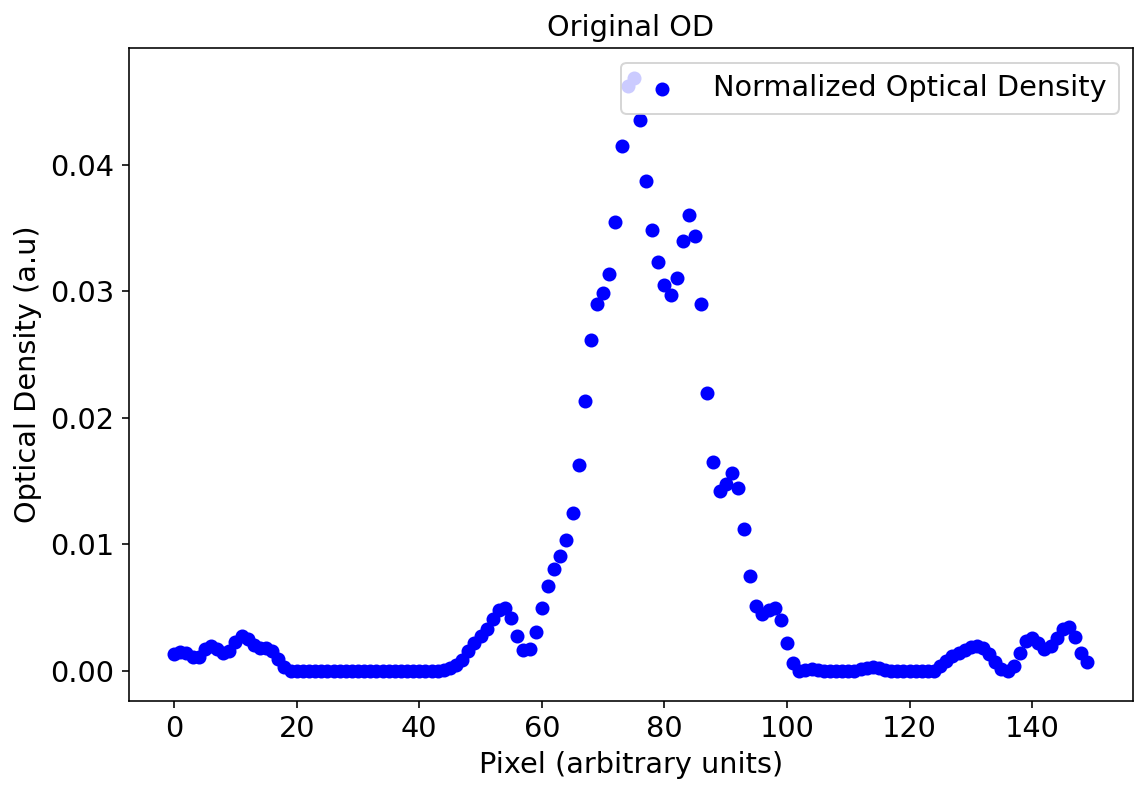

In [13]:
plt.scatter(df['x'],df['od'],c='b',label='Normalized Optical Density')
plt.legend(loc= "upper right")
plt.xlabel("Pixel (arbitrary units)")
plt.ylabel("Optical Density (a.u)")
plt.title("Original OD");

[ 0.91796437 77.19525379  9.08106136]


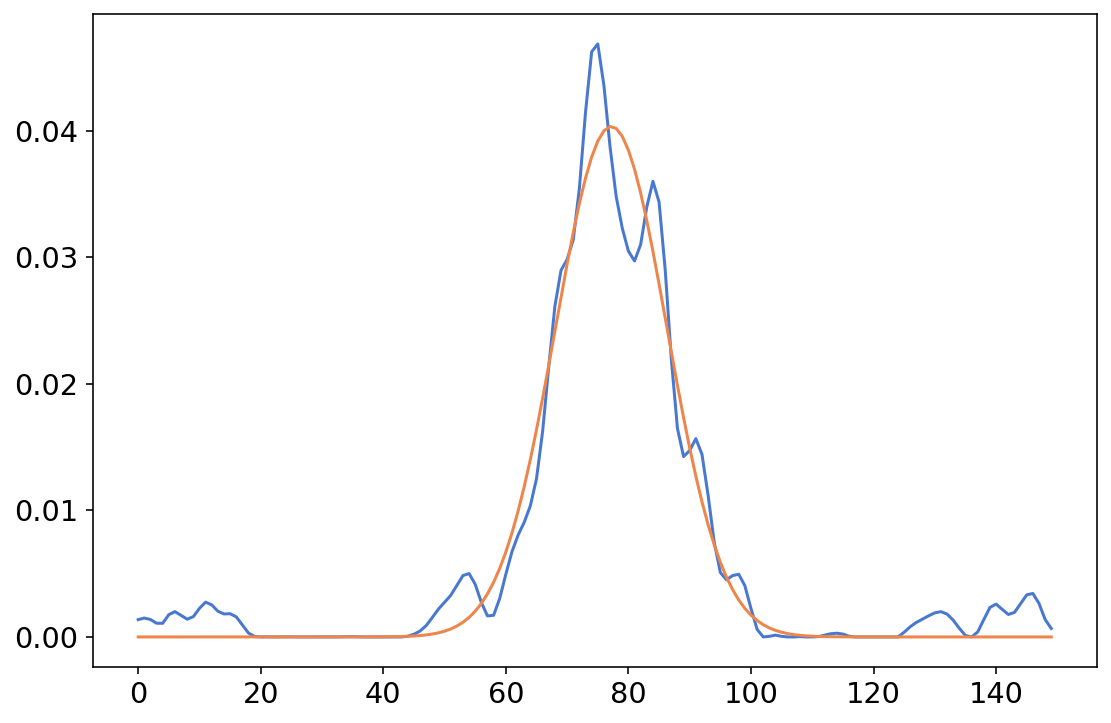

In [14]:
#@title Fit using curve fit
#Fitting function:
from scipy.stats import norm
def gaussian(x, amplitude, mu, sigma):
  return amplitude*norm.pdf(x, loc=mu, scale=sigma)
pop, pcov = curve_fit(gaussian, df["x"], df["od"], p0=[0.04, 80, 20])
print(pop)
plt.plot(df["x"], df["od"])
plt.plot(df["x"], gaussian(df["x"], pop[0], pop[1], pop[2]))

# Markov Chain Monte Carlo Set Up



## Initial Step Set Up

In [178]:
#@title Distribution for normal distribution
root = tfd.JointDistributionCoroutine.Root

def normal_single_regression():
    amplitude = yield root(tfd.Sample(tfd.Normal(1.0,0.08),1))
    mu = yield root(tfd.Sample(tfd.Normal(77.0,10.0),1))
    sigma = yield root(tfd.Sample(tfd.Normal(9.0, 1.0),1))
    
    y = yield tfd.Independent(
        tfd.Normal(
            loc = tfd.Normal(loc=mu, scale=sigma).prob(tf.cast(df['x'],dtype))*amplitude,
            scale = 0.2
        ), reinterpreted_batch_ndims=1
    )

In [179]:
normal_single_regression_jd = tfd.JointDistributionCoroutine(normal_single_regression)
normal_single_log_prob = lambda *args: normal_single_regression_jd.log_prob(args + (tf.cast(df['od'],dtype),))

In [17]:
normal_single_regression_jd.sample(4)

(<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[1.0945357],
        [1.1172789],
        [1.0925555],
        [1.0825721]], dtype=float32)>,
 <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[90.797775],
        [63.557716],
        [84.62332 ],
        [66.659676]], dtype=float32)>,
 <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[10.298899],
        [ 8.179024],
        [ 8.333819],
        [ 7.630516]], dtype=float32)>,
 <tf.Tensor: shape=(4, 150), dtype=float32, numpy=
 array([[ 0.17832074, -0.35147277,  0.11795586,  0.1537179 ,  0.4547452 ,
          0.23409198,  0.26130286, -0.00513948, -0.22747372,  0.17905207,
          0.16254574,  0.16399491,  0.0043547 ,  0.01130607,  0.24594693,
          0.09240906, -0.08022501, -0.2713476 , -0.37165552, -0.15483402,
          0.3381247 ,  0.17951183,  0.28403994, -0.39337656, -0.471804  ,
          0.03966503, -0.13196246,  0.54324365, -0.0996923 , -0.46708733,
         -0.2655327 , -0.16310264, -0.15357552,  0.0

In [17]:
X = tf.cast(tf.constant(range(N)), dtype=tf.float32)
print(X)
sigma = 8.
def gaussian_rates(sigma, mu, w):
  # Xmod = tf.transpose(X*tf.ones(( mu.shape[0], X.shape[0])))
  # print(Xmod)
  # Mumod = mu*tf.ones((X.shape[0], mu.shape[0]))
  # print(Mumod)
  # I0 =  Xmod - Mumod
  # print(I0)
  # I1 = -1.*(tf.pow(I0, 2.)/sigma)
  return w*tf.exp(  -1.*tf.pow(tf.transpose(X*tf.ones(( mu.shape[0], X.shape[0])))-
                    mu*tf.ones((X.shape[0], mu.shape[0])), 2.)/sigma )

def sim_od_dist(sigma, mu, w):
  rate = w*tf.exp(-(tf.pow(X-mu, 2.)/sigma))
  rate = rate.numpy()
  rate[rate < 1e-8] = 1e-10
  #let's try 3 poisson distributions centered at different places.

  # print("rate ", rate)
  return tfd.Independent(tfd.Poisson(rate=tf.convert_to_tensor(rate, dtype=tf.float32)), reinterpreted_batch_ndims=1)
  # return tfd.Independent(tfd.Normal(loc=w*tf.exp(-(tf.pow(X-mu, 2.)/sigma)), scale=2.), reinterpreted_batch_ndims=1)
def sim_od_multiple_dist(sigma, mu, w):
  # rates = gaussian_rates(sigma, mu, w)
  return tfd.Independent(tfd.Normal(loc=tf.reduce_sum(gaussian_rates(sigma,
                                                                     mu, w),
                                                      axis=1),
                                    scale=tf.ones((int(N),))*0.2), reinterpreted_batch_ndims=1)



dists = [
         #w
         tfd.Uniform(low=0.0, high=10000.0),
         #mu
         tfd.Normal(loc=50., scale=8.),
         #sigma
         tfd.Normal(loc=20., scale=10.),
         #total atoms
         tfd.Normal(loc=10000., scale=50.),
         lambda atoms, sigma, mu, w: sim_od_dist(sigma, mu, w)
]
def generate_multiple_dists(n: int):
  return [
         #w
         tfd.Independent(tfd.Uniform(low=[0.0]*n, high=[10000.]*n),reinterpreted_batch_ndims=1),
         #mu
         tfd.Independent(tfd.Normal(loc=[80.]*n, scale=[50.]*n), reinterpreted_batch_ndims=1),
         #sigma
         tfd.Independent(tfd.Normal(loc=[50.]*n, scale=[5.]*n), reinterpreted_batch_ndims=1),
         #total atoms
         tfd.Normal(loc=1000., scale=80.),
         lambda atoms, sigma, mu, w: sim_od_multiple_dist(sigma, mu, w)
        ]


od_dist = tfd.JointDistributionSequential(dists)
od_multiple_dist = tfd.JointDistributionSequential(generate_multiple_dists(3))
print(od_multiple_dist.resolve_graph())
s = od_multiple_dist.sample(1)
print("sample ", s)
od_multiple_dist.log_prob_parts(s)


tf.Tensor(
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.], shape=(150,), dtype=float32)
(('w', ()), ('mu', ()), ('sigma', ()), ('atoms', ()), ('x', ('atoms', 'sigma', 'mu', 'w')))
sample  [<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 717.3693, 1468.1792, 7610.4927]], dtype=

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-27.631021], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-15.56822], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-9.523273], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-5.404342], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19.422792>]

In [ ]:
def target_log_prob_tr(*init_state):
  try:
    #print("init st = ", init_state, "\n len init", len(init_state))
    atoms = init_state[3]
    inp = list(init_state)+[Slice*atoms]
    return od_dist.log_prob(inp)
    #print("inp ", inp, "\n", len(inp))
  except Exception as e:
    # print(e)
    atoms = init_state[0][3]
    # print(atoms)
    inp = list(init_state[0])+[Slice*atoms]
    # print(inp)
    try:
      return od_dist.log_prob(inp)
    except Exception as e:
      print(e)
      print(init_state)
      exit()

def target_log_prob_multiple_normals(*init_state):
  try:
    # print("init st = ", init_state, "\n len init", len(init_state))
    atoms = init_state[3]
    inp = list(init_state)+[Slice*atoms]
    return od_multiple_dist.log_prob(inp)
    #print("inp ", inp, "\n", len(inp))
  except Exception as e:
    # print(e)
    atoms = init_state[0][3]
    # print(atoms)
    inp = list(init_state[0])+[Slice*atoms]
    # print(inp)
    try:
      return od_multiple_dist.log_prob(inp)
    except Exception as e:
      print(e)
      print(init_state)
      exit()

In [ ]:
#creation of the distribution used:
# dist = closed_joint_dist_gen(int(N)) #N is the number of pixels in the slice, set globally
# dist = 
#how many chains should we use?
chains = 1
#sample it:
# start = dist.sample()
step_size = 0.1

In [ ]:
#@title Bijectors
# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
# unconstraining_bijectors = [
#     tfp.bijectors.Exp(),       # Maps a positive real to R. for x_tail
#     tfp.bijectors.Exp(), # for lambda center
#     tfp.bijectors.Exp(), # for lambda left
#     tfp.bijectors.Exp(), # for lambda right
#     tfp.bijectors.Exp(), # for sigma center
#     tfp.bijectors.Exp(), # for sigma left
#     tfp.bijectors.Exp(), # for sigma right
#     tfp.bijectors.Exp(), # for sigmai
#     tfp.bijectors.Exp(), # for amplitude
#     tfp.bijectors.Sigmoid(), #for mix center
#     tfp.bijectors.Sigmoid() #for mix left
#     # tfp.bijectors.Sigmoid(),       # Maps [0,1] to R. for gamma
#     # tfp.bijectors.Sigmoid(),   # Maps [0,1] to R. for delta
#     # tfp.bijectors.Exp(),        # Maps a positive real to R. for I0
#     # tfp.bijectors.Exp(), # Maps a positive real to R. for R0
#     # tfp.bijectors.Sigmoid() # Maps [0,1] to R. for care
# ]
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R. for x_tail
    tfp.bijectors.Exp(), # for mu
    tfp.bijectors.Exp(), # for sigma
    tfp.bijectors.Exp() # for atom number
    # tfp.bijectors.Exp(), # for lambda right
    # tfp.bijectors.Exp(), # for sigma center
    # tfp.bijectors.Exp(), # for sigma left
    # tfp.bijectors.Exp(), # for sigma right
    # tfp.bijectors.Exp(), # for sigmai
    # tfp.bijectors.Exp(), # for amplitude
    # tfp.bijectors.Sigmoid(), #for mix center
    # tfp.bijectors.Sigmoid() #for mix left
    # tfp.bijectors.Sigmoid(),       # Maps [0,1] to R. for gamma
    # tfp.bijectors.Sigmoid(),   # Maps [0,1] to R. for delta
    # tfp.bijectors.Exp(),        # Maps a positive real to R. for I0
    # tfp.bijectors.Exp(), # Maps a positive real to R. for R0
    # tfp.bijectors.Sigmoid() # Maps [0,1] to R. for care
]

In [19]:
#@title Starting MCMC Code
from google.colab import output
chains = 1
local_runtime = False #@param {type:"boolean"}
# wrap the mcmc sampling call in a @tf.function to speed it up
#@tf.function(autograph=False)
calls = 0
def graph_sample_chain(*args, **kwargs):
  print("current = ",kwargs["current_state"])
  start_time = time.time()
  out = tfp.mcmc.sample_chain(*args, **kwargs)
  print(f"It took: {(time.time()-start_time)/60} min")
  return out
def trace_fn(_, pkr):
    return (
        #pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
           )
# r0, gamma, delta, I0, rho, _ = mdl_ols_batch.sample(nchain)
# init_state = [b0, b1]
# # step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1]]
# target_log_prob_fn = lambda *init_state: mdl_ols_batch.log_prob(
#     list(init_state) + [Y_np])
num_burnin_steps = 10000
num_results = 5000



print(step_size)
kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_multiple_normals,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=False),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

#kernel.bootstrap_results(init_state)

# # Sample from the chain.
# [
#     r0_samples,
#     gamma_samples,
#     delta_samples,
#     I0_samples,
#     posterior_care,
# ],
kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=init, #put init in here if you want to start from init
    #previous_kernel_results=kernel.bootstrap_results(initial_chain_state),
    kernel = kernel, parallel_iterations=chains)
#save the kernel_results to drive:
[w_samples, mu_samples, sigma_samples, atom_samples], extra = kernel_results
# [xtail_samples, lambdac_samples, lambdal_samples, lambdar_samples, sigmac_samples, sigmal_samples, sigmar_samples, sigmai_samples, amplitude_samples, mixc_samples, mixl_samples], extra = kernel_results
#save data as plain npz files:
base = r"Desktop/covid19/" if local_runtime else r"/content/drive/My Drive/Colab Notebooks/Weld Lab/data/"
output_path = base + f"out/output_run18_{time.strftime('%Y-%m-%d-%H:%M %Z', time.localtime())}.npz"
np.savez(output_path, w_samples, mu_samples, sigma_samples, atom_samples)# xtail_samples, lambdac_samples, lambdal_samples, lambdar_samples, sigmac_samples, sigmal_samples, sigmar_samples, sigmai_samples, amplitude_samples, mixc_samples, mixl_samples)

# notify.send("Finished!")
#np.savez("/content/drive/My Drive/Colab Notebooks/out/output_acceptance.npz", tf.cast(extra.inner_results.inner_results.is_accepted,dtype=tf.float32)).numpy(), extra.inner_results.inner_results.accepted_results.step_size[-100:])
# tau_samples = tf.floor(posterior_care * tf.cast(tf.size(cases),dtype=tf.float32))
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

NameError: ignored

In [ ]:
#@title Calculate Acceptance Rate
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(extra.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(extra.inner_results.inner_results.accepted_results.step_size[-100:])))
# extra
# step_size = [o[-1] for o in extra.inner_results.inner_results.accepted_results.step_size]
step_size =  tf.reduce_mean(extra.inner_results.inner_results.accepted_results.step_size[-100:])
tf.reduce_mean(extra.inner_results.inner_results.accepted_results.target_log_prob, axis=0)
# step_size = 0.1

# NUTS Kernel

Code taken from https://adamhaber.github.io/post/nuts/

In [180]:
#@title trace to Arviz function
# using pymc3 naming conventions, with log_likelihood instead of lp so that ArviZ can compute loo and waic
sample_stats_name = ['log_likelihood','tree_size','diverging','energy','mean_tree_accept'] #, "step_size"]

def tfp_trace_to_arviz(
    tfp_trace,
    var_names=None, 
    sample_stats_name=sample_stats_name):
    
    samps, trace = tfp_trace
    if var_names is None:
        var_names = ["var " + str(x) for x in range(len(samps))]
    sample_stats = {}
    for k, v in zip(sample_stats_name, trace):
      try:
        sample_stats[k] = v.numpy().T
      except:
        sample_stats[k] = v
    #sample_stats  = {k: v.numpy().T for k, v in zip(sample_stats_name, trace)}
    # print(samps)
    posterior = {name : np.transpose(samp.numpy(), axes=[1, 0, 2]) for name, samp in zip(var_names, samps)}
    print(posterior["amplitude"].shape)
    return az.from_dict(posterior=posterior, sample_stats=sample_stats)

In [181]:
#@title Trace Function for NUTS
def trace_fn(_, pkr):  
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio,
        # pkr.inner_results.inner_results.step_size
    )

In [182]:
#@title Nuts template
n_chains = 10
def run_nuts_template(
    trace_fn,
    target_log_prob_fn,
    inits,
    bijectors_list=None, 
    num_steps=500,
    num_burnin=500,
    n_chains=n_chains):
    
    step_size = np.random.rand(n_chains, 1)*.5 + 1.
    
    if not isinstance(inits, list):
        inits = [inits]
        
    if bijectors_list is None:
        bijectors_list = [tfb.Identity()]*len(inits)

    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn,
                step_size=[step_size]*len(inits)
            ),
            bijector=bijectors_list
        ),
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*num_burnin),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
              inner_results=pkr.inner_results._replace(step_size=new_step_size)
          ),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )
    
    res = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=num_burnin,
        current_state=inits,
        kernel=kernel,
        trace_fn=trace_fn
    )
    return res

In [183]:
#@title Optimized functions
run_nuts = partial(run_nuts_template, trace_fn)

run_nuts_opt = tf.function(run_nuts)
run_nuts_defun = tf.function(run_nuts, autograph=False)
run_nuts_defun_xla = tf.function(run_nuts, autograph=False, experimental_compile=True)

In [184]:
#@title Run nuts
%%time
init = [tf.ones((n_chains,1))*0.92, tf.ones((n_chains,1))*77.2, tf.ones((n_chains,1))*9.08]
res = run_nuts_defun_xla(normal_single_log_prob, init, num_steps=1000, num_burnin=10000)
# run_nuts_template(trace_fn, normal_single_log_prob, init)

CPU times: user 49.8 s, sys: 145 ms, total: 49.9 s
Wall time: 50 s


(10, 1000, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3688e207f0>,
      dtype=object)

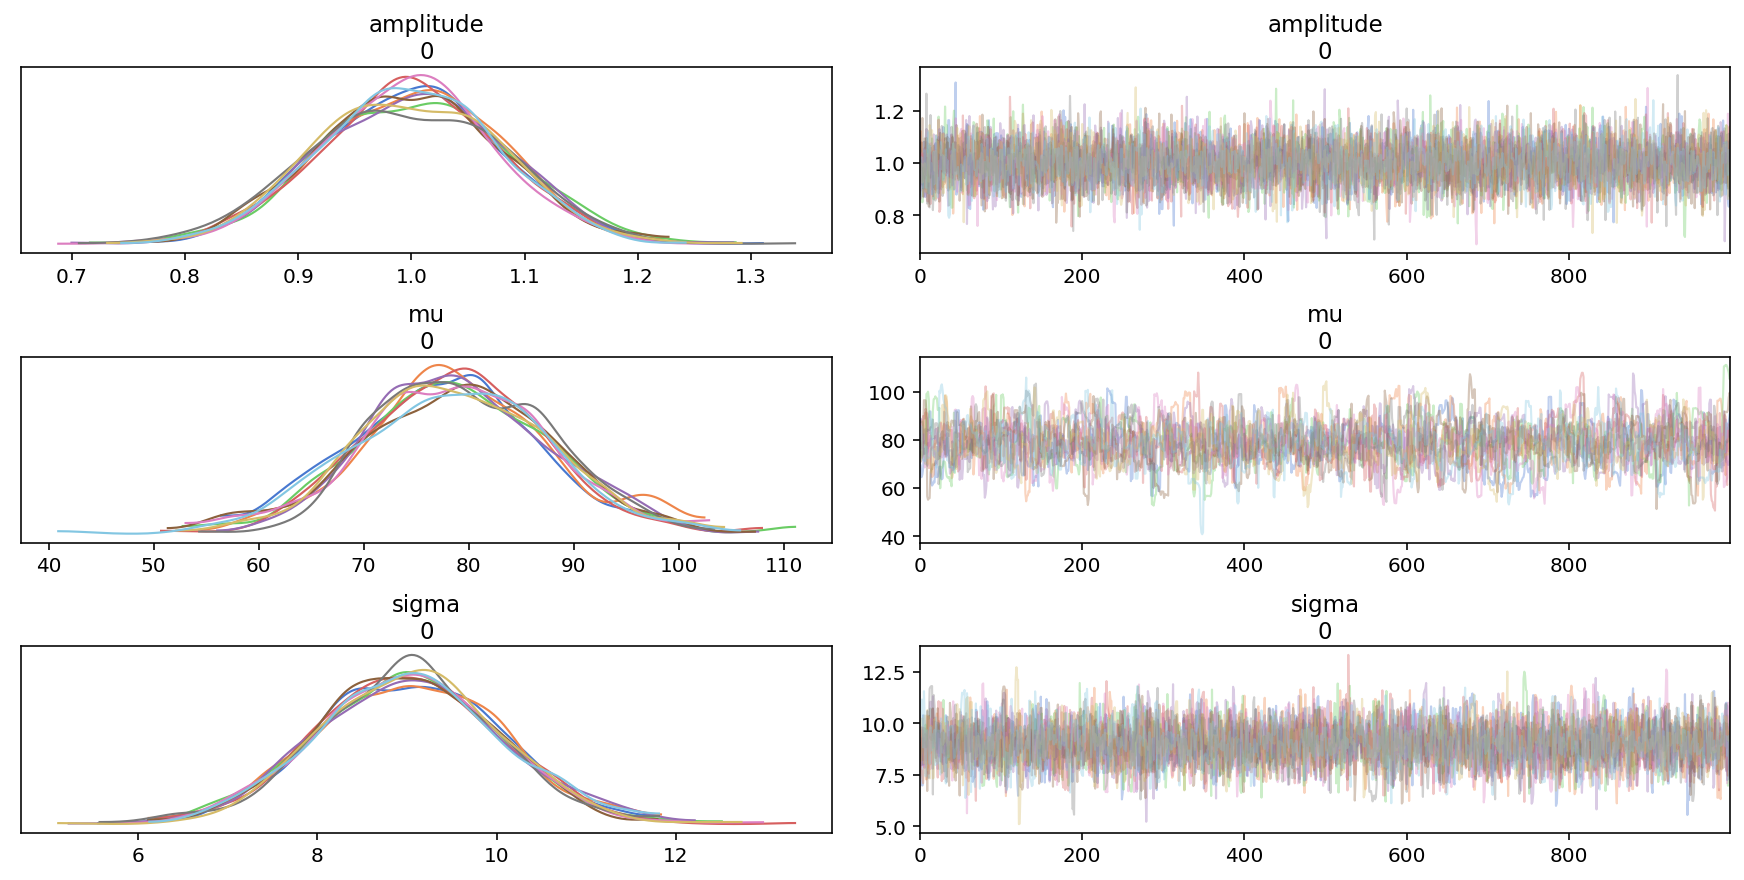

In [23]:

# trace1 = az.from_tfp(res.trace, var_names=["amplitude", "mu", "sigma"])
t = tfp_trace_to_arviz(res, var_names=["amplitude", "mu", "sigma"])
# res[:-1]
# t
az.plot_trace(t)
# az.summary(trace1)
# res.all_states
# res.trace

In [24]:
az.summary(t)
# t.sample_stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
amplitude[0],0.999,0.080,0.854,1.149,0.001,0.001,8495.0,8449.0,8480.0,7628.0,1.0
mu[0],78.741,8.899,61.857,95.615,0.237,0.168,1408.0,1408.0,1413.0,1592.0,1.0
sigma[0],9.016,1.006,7.113,10.873,0.012,0.008,7117.0,7060.0,7111.0,4880.0,1.0


In [25]:
amplitude, mu, sigma = az.summary(t)["mean"]
az.summary(t)["sd"]["amplitude[0]"]

0.08

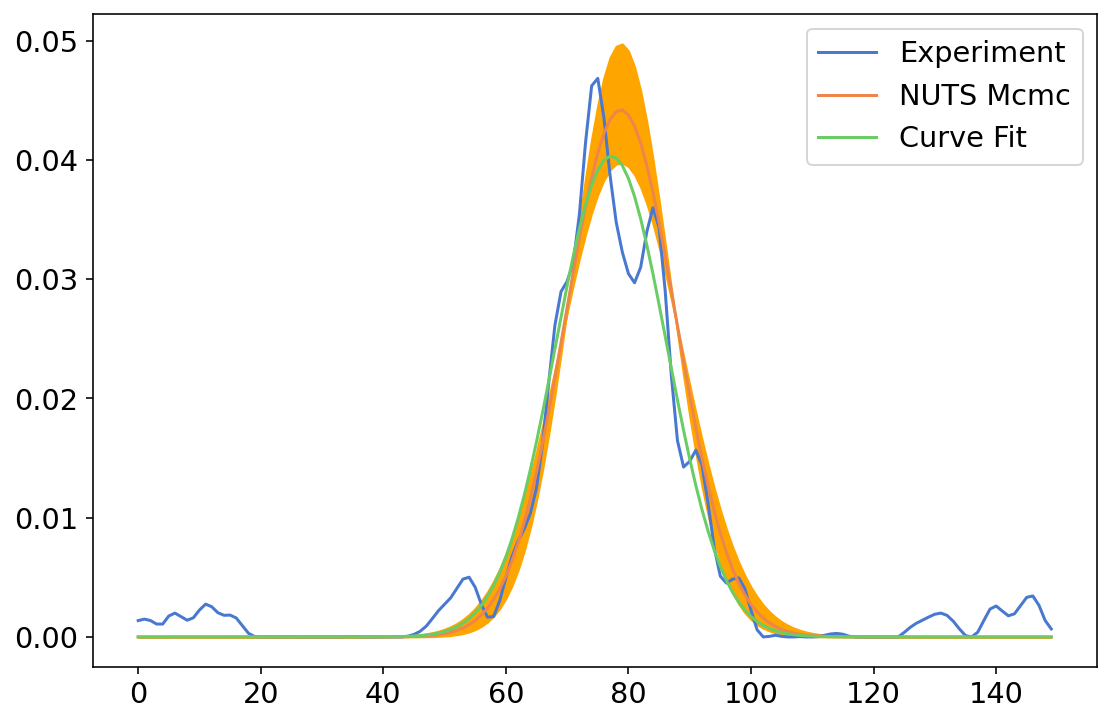

In [26]:
plt.plot(df["x"], df["od"], label="Experiment")
plt.plot(df["x"], gaussian(df["x"], amplitude, mu, sigma), label="NUTS Mcmc")
plt.fill_between(df["x"], gaussian(df["x"], amplitude-0*az.summary(t)["sd"]["amplitude[0]"],
                                   mu-0*az.summary(t)["sd"]["mu[0]"], sigma-az.summary(t)["sd"]["sigma[0]"]),
                 gaussian(df["x"], amplitude+0*az.summary(t)["sd"]["amplitude[0]"], mu+0*az.summary(t)["sd"]["mu[0]"], sigma+az.summary(t)["sd"]["sigma[0]"]), color="orange")
# plt.fill_between(df["x"], gaussian(df["x"], amplitude+az.summary(t)["sd"]["amplitude[0]"],
#                                    mu+az.summary(t)["sd"]["mu[0]"], sigma+az.summary(t)["sd"]["sigma[0]"]),
#                  gaussian(df["x"], amplitude-az.summary(t)["sd"]["amplitude[0]"], mu-0*az.summary(t)["sd"]["mu[0]"], sigma-az.summary(t)["sd"]["sigma[0]"]), color="orange")

plt.plot(df["x"], gaussian(df["x"], pop[0], pop[1], pop[2]), label="Curve Fit")
plt.legend()